# <center>Local Fourier Analysis of P-Multigrid<br>with LFAToolkit.jl</center>

### <center>Jeremy L Thompson</center>

### <center>Jed Brown</center>

Local Fourier Analysis Toolkit is a Julia package for analysis and tuning of multigrid and smoothing techniques for finite element operators with arbitrary, user provided weak forms of partial differential equations

<br>
<center>
    <a href="
         https://www.github.com/jeremylt/LFAToolkit.jl">github.com/jeremylt/LFAToolkit.jl</a> 
</center>
<style>
//change background settings {}
div.slide-background {
	border-top: 30px midnightblue solid;
	border-bottom: 30px midnightblue solid;
}
</style>

## <center>Overview</center>

* Introduction
* Mathematical Background
 - Operator Representation
 - Local Fourier Analysis
* PDE Examples
 - Poisson Problem
 - Neo-Hookean Hyperelasticity
* Smoother Examples
 - Jacobi
 - Chebyshev
* Multigrid Examples
 - p-multigrid
 - h-multigrid
* Agressive Coarsening
 - 1D Scalar Poisson
 - 2D Scalar Poisson
 - Neo-Hookean Hyperelasticity
* Development Roadmap
* References

## <center>Introduction</center>

Local Fourier Analysis (LFA) of multigrid and preconditioning methods
* models error reduction across frequencies
* predicts convergence of methods
* facilitates parameter tuning

The technique was first introduced by Brandt in 1977<sup>[2]</sup> for h-multigrid with finite differences

Technique was later adapted for finite elements and additional preconditioners

LFAToolkit.jl does LFA for
* user defined weak forms of PDE
* with user defined or arbitrary order polynomial bases
* for h and p multigrid with various smoothers
* and facilitates parameter optimization

## <center>Mathematical Background</center>

Mathematical representation of finite element operators and Local Fourier Analysis in LFAToolkit.jl

## <center>Mathematical Background</center>
### <center>Operator Representation</center>

LFAToolkit uses a finite element operator representation designed to facilitate matrix-free implementations <sup>[3]</sup>

This representation supports arbitrary second order PDEs

<br>

$$
\int_{\Omega} v \cdot f_0 \left( u, \nabla u \right) + \nabla v : f_1 \left( u, \nabla u \right) = \int_{\Omega} f v, \forall v \in V
$$

for some suitable $V \subseteq H_0^1 \left( \Omega \right)$

where

* $\cdot$ represents contraction over fields
* $:$ represents contraction over fields and spatial dimensions

## <center>Mathematical Background</center>
### <center>Operator Representation</center>

This weak form can be discretized by selecting a finite element basis

<br>

$$
\color{Maroon}{\mathbf{A}} u = \sum_e \mathcal{E}^T_e \left[
  \left( \color{RoyalBlue}{\mathbf{B}}_0^e \right)^T \color{RoyalBlue}{\mathbf{W}}^e \Lambda \left( \color{YellowGreen}{\mathbf{f_0}} \left( u^e, \nabla u^e \right) \right)
  + \sum_{i = 1}^d \left( \color{RoyalBlue}{\mathbf{B}}_i^e \right)^T \color{RoyalBlue}{\mathbf{W}}^e \Lambda \left( \color{YellowGreen}{\mathbf{f_1}} \left( u^e, \nabla u^e \right) \right)
\right]
$$

where

<br>

<p style="margin-left:10%;">$u^e = \color{RoyalBlue}{\mathbf{B}}_0^e \mathcal{E}^e u$ and $\nabla u^e = \lbrace \color{RoyalBlue}{\mathbf{B}}_i^e \mathcal{E}^e u \rbrace_{i = 1}^d$</p>

## <center>Mathematical Background</center>
### <center>Operator Representation</center>

This operator can be represented as

<br>

$$
\color{Maroon}{\mathbf{A}} = \mathbf{G}^T \color{RoyalBlue}{\mathbf{B}}^T \color{YellowGreen}{\mathbf{D}} \color{RoyalBlue}{\mathbf{B}} \mathbf{G}
$$

where

* $\color{Maroon}{\mathbf{A}}$ - full finite element operator
* $\mathbf{G}$ - element restriction or assembly operator
* $\color{RoyalBlue}{\mathbf{B}}$ - element basis operator (providing $\color{RoyalBlue}{\mathbf{B}}_i$)
* $\color{YellowGreen}{\mathbf{D}}$ - diagonal pointwise weak form operator (from $\color{YellowGreen}{\mathbf{f_0}}$, $\color{YellowGreen}{\mathbf{f_1}}$, and element geometry)

## <center>Mathematical Background</center>
### <center>Operator Representation</center>

This representation facilitates matrix-free implementation, such as in libCEED<sup>[1]</sup>
<center>
<a href="https://github.com/CEED/libCEED">github.com/CEED/libCEED</a>
<img src="https://raw.githubusercontent.com/CEED/libCEED/main/doc/img/libCEED.png">
</center>

Note: improved libCEED.jl integration on development roadmap

## <center>Mathematical Background</center>
### <center>Local Fourier Analysis</center>

LFA investigates the local properties of the descretized operator

Consider a scalar Toeplitz operator $L_h$ on the infinite 1D grid $G_h$

<br>

$$
L_h \mathrel{\hat{=}} \left[ s_\kappa \right]_h \left( \kappa \in V \right)\\
L_h w_h \left( x \right) = \sum_{\kappa \in V} s_\kappa w_h \left( x + \kappa h \right)
$$

where

* $V \subset \mathcal{Z}$ is an index set
* $s_\kappa \in \mathcal{R}$ are constant coefficients
* $w_h \left( x \right)$ is a $l^2$ function on $G_h$

## <center>Mathematical Background</center>
### <center>Local Fourier Analysis</center>

If for all $\varphi \left( \theta, x \right)$

<br>

$$
L_h \varphi \left( \theta, x \right) = \tilde{L}_h \left( \theta \right) \varphi \left( \theta, x \right)
$$

then $\tilde{L}_h \left( \theta \right) = \sum_{\kappa \in V} s_\kappa e^{\imath \theta \kappa}$ is the **symbol** of $L_h$

## <center>Mathematical Background</center>
### <center>Local Fourier Analysis</center>

For a system of equations, such as the $p \times p$ linear system of equations for a scalar problem on a single $p$ order finite element

<br>

$$
\tilde{L}_h =
\begin{bmatrix}
    \tilde{L}_h^{1, 1}  &&  \cdots  &&  \tilde{L}_h^{1, p}  \\
    \vdots              &&  \vdots  &&  \vdots              \\
    \tilde{L}_h^{p, 1}  &&  \cdots  &&  \tilde{L}_h^{p, p}  \\
\end{bmatrix}
$$

Multi-component equations are represented in a similar fashion

## <center>Mathematical Background</center>
### <center>Operator Representation + Local Fourier Analysis</center>

We combine these two formulations with a Fourier mode localization operator in 1D

<br>

$$
\tilde{\color{Maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right) = \mathbf{Q}^T \left( \color{Maroon}{\mathbf{A}}_e \odot \left[ e^{\imath \left( x_i - x_j \right) \theta / h} \right] \right) \mathbf{Q}
$$

where

* $\color{Maroon}{\mathbf{A}}_e = \color{RoyalBlue}{\mathbf{B}}^T \color{YellowGreen}{\mathbf{D}} \color{RoyalBlue}{\mathbf{B}}$
* $\mathbf{Q} = 
\begin{bmatrix}
    I    \\
    e_0  \\
\end{bmatrix} =
\begin{bmatrix}
    1       &&  0       &&  \cdots  &&  0       \\
    0       &&  1       &&  \cdots  &&  0       \\
    \vdots  &&  \vdots  &&  \vdots  &&  \vdots  \\
    0       &&  0       &&  \cdots  &&  1       \\
    1       &&  0       &&  \cdots  &&  0       \\
\end{bmatrix}
$

Higher dimensions use with a Kronecker product of the 1D localization operator

## <center>PDE Examples</center>

PDEs can be represented in LFAToolkit.jl by providing bases, a mesh, and a pointwise representation of the weak form

## <center>PDE Example</center>
### <center>Poisson Problem</center>

As the classic example, let's look at the scalar Poisson problem

<br>

$$
\int \nabla v \nabla u = \int f v
$$

<br>

$$
\color{Maroon}{\mathbf{A}}_e = \color{RoyalBlue}{\mathbf{B}}^T \color{YellowGreen}{\mathbf{D}} \color{RoyalBlue}{\mathbf{B}}
$$

$\color{RoyalBlue}{\mathbf{B}}$ represents the finite element basis, such as a H1 Lagrange basis on Gauss-Lobatto points

$\color{YellowGreen}{\mathbf{D}}$ represents the pointwise application of the weak form

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 1
mesh = Mesh1D(1.0)
# basis
p = 3
ncomp = 1
basis = TensorH1LagrangeBasis(p, p+1, ncomp, dim)
# weak form
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    return dv = du*w[1]
end

# operator
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
]
outputs = [OperatorField(basis, [EvaluationMode.gradient])]
A = Operator(diffusionweakform, mesh, inputs, outputs)

# compute symbols
θ = [π]
symbol = computesymbols(A, θ)

## <center>Poisson Example</center>

<center>1D quadratic elements</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# compute full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # compute
    maxeigenvalues = zeros(numberruns)

    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Diffusion Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # compute
    maxeigenvalues = zeros(numberruns, numberruns)

    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i, j] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        title="Diffusion Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Poisson Example</center>

<center>2D quadratic elements</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# compute full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # compute
    maxeigenvalues = zeros(numberruns)

    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Diffusion Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # compute
    maxeigenvalues = zeros(numberruns, numberruns)

    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i, j] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        title="Diffusion Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>PDE Example</center>
### <center>Neo-Hookean Hyperelasticity</center>

The strong form of the static balance of linear-momentum at finite strain is given by

<br>

$$
-\nabla_x \cdot \mathbf{P} - \rho_0 \mathbf{g} = \mathbf{0}
$$

where $-\nabla_k$ is the gradient with respect to the reference configuration, $\mathbf{P}$ is the first Piola-Kirchhoff stress tensor, $\rho_0$ is the reference mass density, and $\mathbf{g}$ is the forcing function

The first Piola-Kirchhoff stress tensor is given by

<br>

$$
\mathbf{P} = \mathbf{F} \mathbf{S}
$$

where $\mathbf{F}$ is the deformation gradient and $\mathbf{S}$ is the second Piola-Kirchhoff stress tensor

In [ ]:
# setup
using LFAToolkit
using LinearAlgebra

# fem parameters
dim = 3
mesh = Mesh3D(1.0, 1.0, 1.0)
p = 3
ncomp = 3
basis = TensorH1LagrangeBasis(p, p+1, ncomp, dim)

# constants
e = 1E6                     # Young's modulus
ν = 0.3                     # Poisson's ratio
K = e/(3*(1 - 2*ν))         # bulk modulus
λ = e*ν/((1 + ν)*(1 - 2*ν)) # Lamé parameters
μ = e/(2*(1 + ν))

# state vector
gradu = [1; 2; 3]*ones(1, 3);

In [ ]:
# Neo-Hookean weak form
function neohookeanweakform(deltadu::Array{Float64}, w::Array{Float64})
    # dP = dF S + F dS

    F = gradu + I
    J = det(F)
    # Green-Lagrange strain tensor
    E = (gradu*gradu' + gradu'*gradu)/2
    # right Cauchy-Green tensor
    C = 2*E + I
    C_inv = C^-1
    # second Piola-Kirchhoff
    S = λ*log(J)*C_inv + 2*μ*C_inv*E

    deltadu = deltadu'
    dF = deltadu + I
    deltaE = (deltadu*deltadu' + deltadu'*deltadu)/2
    dS = λ*sum(C_inv.*deltaE)*C_inv + 2*(μ - λ*log(J))*C_inv*deltaE*C_inv
    dP = dF*S + F*dS

    return [dP']
end

In [ ]:
# linearized Neo-Hookean operator
inputs = [
    OperatorField(
        basis,
        [EvaluationMode.gradient],
        "gradent of deformation"
        ),
    OperatorField(
        basis,
        [EvaluationMode.quadratureweights],
        ),
]
outputs = [
    OperatorField(
        basis,
        [EvaluationMode.gradient],
        "test function gradient of deformation",
    ),
]
A = Operator(neohookeanweakform, mesh, inputs, outputs)

## <center>Smoother Examples</center>

The error propagation operator for smoothers is given by

<br>

$$
\mathbf{S} = \mathbf{I} - \mathbf{M}^{-1} \color{Maroon}{\mathbf{A}}
$$

where $\mathbf{M}^{-1}$ is the smoothing operator

## <center>Smoother Example</center>
### <center>Jacobi</center>

Let's consider simple Jacobi smoothing

<br>

$$
\mathbf{M}^{-1} = \omega \space \text{diag} \left( \color{Maroon}{\mathbf{A}} \right)^{-1}
$$

The error propagation **symbol** is given by

<br>

$$
\tilde{\mathbf{S}} \left( \omega, \mathbf{\theta} \right) = \mathbf{I} - \omega \space \text{diag} \left( 
\tilde{\color{Maroon}{\mathbf{A}}} \right) \tilde{\color{Maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right)
$$

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# operator
A = GalleryOperator("diffusion", p, p+1, mesh)
S = Jacobi(A)

# compute symbols
ω = [1.0] # smoothing weight
θ = [π, π]
symbol = computesymbols(S, ω, θ)

## <center>Jacobi Example</center>

<center>1D quadratic elements, ω = 0.77</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Jacobi smoother
jacobi = Jacobi(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [0.77]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/256
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Jacobi Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [1.0]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Jacobi Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Jacobi Example</center>

<center>2D quadratic elements, ω = 1.0</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Jacobi smoother
jacobi = Jacobi(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [1.0]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/128
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Jacobi Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [1.0]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Jacobi Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Smoother Example</center>
### <center>Chebyshev</center>

Let's consider Chebyshev polynomial smoothing

<br>

$$
\mathbf{M}^{-1} = \rho_q \left( \text{diag} \left( \color{Maroon}{\mathbf{A}} \right)^{-1} \color{Maroon}{\mathbf{A}} \right)
$$

where

$\rho$ is derived from the Chebyshev polynomials<sup>[5]</sup> and $q$ is the polynomial order of the smoother

The error propagation **symbol** is given by

<br>

$$
\tilde{\mathbf{S}} \left( q, \mathbf{\theta} \right) = \mathbf{I} - \rho_q \left( \text{diag} \left( \tilde{\color{Maroon}{\mathbf{A}}} \right)^{-1} \tilde{\color{Maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right) \right) \tilde{\color{Maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right)
$$

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# operator
A = GalleryOperator("diffusion", p, p+1, mesh)
S = Chebyshev(A)

# compute symbols
ρ = [3] # Chebyshev order
θ = [π, π]
symbol = computesymbols(S, ρ, θ)

## <center>Chebyshev Example</center>

<center>1D quadratic elements, ω = 3</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Chebyshev smoother
chebyshev = Chebyshev(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/256
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Chebyshev Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Chebyshev Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Chebyshev Example</center>

<center>2D quadratic elements, ω = 3</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Chebyshev smoother
chebyshev = Chebyshev(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Chebyshev Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Chebyshev Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Multigrid Examples</center>

The error propagation of a multigrid method is given by

<br>

$$
\mathbf{M}_{TMG} = \mathbf{S}_f \left( \mathbf{I} - \mathbf{P}_{ctof} \color{Maroon}{\mathbf{A}}_c^{-1} \mathbf{R}_{ftoc} \color{Maroon}{\mathbf{A}}_f \right) \mathbf{S}_f
$$

where the grid transfer opertors $\mathbf{P}_{ctof}$ and $\mathbf{R}_{ftoc}$ determine the type of multigrid method

Error propagation symbol is given by the symbols of the components

## <center>Multigrid Example</center>
### <center>P-Multigrid</center>

Prolongation given by interpolating low order basis functions to high order basis nodes, restriction by the transpose

<br>

$$
\mathbf{P}_{ctof} = \mathbf{P}_f^T \color{YellowGreen}{\mathbf{D}}_{scale} \color{RoyalBlue}{\mathbf{B}}_{ctof} \mathbf{P}_c, \ \ \mathbf{R}_{ftoc} = \mathbf{P}_{ctof}^T
$$

In [ ]:
using LFAToolkit
using Plots

# Lagrange plotting function
function lagrange(x, i, p)
    points = LFAToolkit.lobattoquadrature(p, false)
    xi = points[i]
    return prod([if (xi == xj) 1 else (x - xj)/(xi - xj) end for xj in points])
end

# coarse element
x = -1:0.05:1
pcoarse = 3
coarse = [[lagrange(xx, i, pcoarse) for xx in x] for i in 1:pcoarse]
fine = [[lagrange(xx, i, 4) + 1.25 for xx in x] for i in 1:4]
plot(
    x,
    coarse,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    color = :blue,
    size = (600, 300),
)
xi = LFAToolkit.lobattoquadrature(pcoarse, false)
yi = zeros(pcoarse)
scatter!(
    xi,
    yi,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    markersize = 5,
    markercolor = :black,
)

# fine element
shift = 1.25
pfine = 5
fine = [[lagrange(xx, i, pfine) + shift for xx in x] for i in 1:pfine]
plot!(
    x,
    fine,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    color = :green
)
xi = LFAToolkit.lobattoquadrature(pfine, false)
yi = ones(pfine)*shift
scatter!(
    xi,
    yi,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    markersize = 5,
    markercolor = :black,
)

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# setup
finep = 3
coarsep = 2
ncomp = 1

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# prolongation basis
ctofbasis = TensorH1LagrangeBasis(coarsep, finep, ncomp, dim, lagrangequadrature = true)

# Chebyshev smoother
S = Chebyshev(finediffusion)

In [ ]:
# p-multigrid preconditioner
M = PMultigrid(finediffusion, coarsediffusion, S, [ctofbasis])

# compute symbols
ρ = [3]
v = [1, 1]
θ = [π, π]
symbol = computesymbols(M, ρ, v, θ)

## <center>Multigrid Example</center>

<center>1D quadratic to linear elements, 3rd order Chebyshev smoother</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
finep = 3
coarsep = 2
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="P-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="P-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Multigrid Example</center>

<center>2D quadratic to linear elements, 3rd order Chebyshev smoother</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
finep = 3
coarsep = 2
numbercomponents = 1
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="P-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="P-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Multigrid Example</center>
### <center>H-Multigrid</center>

H-multigrid prolongation is interpolation from a single element to a *macro-element* with multiple sub *micro-elements*

In [ ]:
using LFAToolkit
using Plots

# Lagrange plotting function
function lagrange(x, i, p)
    points = LFAToolkit.lobattoquadrature(p, false)
    xi = points[i]
    return prod([if (xi == xj) 1 else (x - xj)/(xi - xj) end for xj in points])
end

# coarse element
x = -1:0.05:1
pcoarse = 2
coarse = [[lagrange(xx, i, pcoarse) for xx in x] for i in 1:pcoarse]
fine = [[lagrange(xx, i, 4) + 1.25 for xx in x] for i in 1:4]
plot(
    x,
    coarse,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    color = :blue,
    size = (600, 300),
)
xi = LFAToolkit.lobattoquadrature(pcoarse, false)
yi = zeros(pcoarse)
scatter!(
    xi,
    yi,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    markersize = 5,
    markercolor = :black,
)

# left fine element
shift = 1.25
pfine = 2
x = x ./ 2 .- 0.5
fine = [[yi .+ shift] for yi in coarse]
plot!(
    x,
    fine,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    color = :green
)
xi = LFAToolkit.lobattoquadrature(pfine, false) ./ 2 .- 0.5
yi = ones(pfine)*shift
scatter!(
    xi,
    yi,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    markersize = 5,
    markercolor = :black,
)

# right fine element
shift = 1.25
x = x .+ 1
fine = [[yi .+ shift] for yi in coarse]
plot!(
    x,
    fine,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    color = :green
)
xi = LFAToolkit.lobattoquadrature(pfine, false) ./ 2 .+ 0.5
yi = ones(pfine)*shift
scatter!(
    xi,
    yi,
    yticks = false,
    yshowaxis = false,
    grid = false,
    legend = false,
    markersize = 5,
    markercolor = :black,
)

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# bases 
ncomp = 1
p = 2
numelemfine1d = 2

# weak form
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    dv = du*w[1]
    return [dv]
end

In [ ]:
# operators
# -- fine
basis = TensorH1LagrangeMacroBasis(p, p+1, ncomp, dim, numelemfine1d);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
finediffusion = Operator(diffusionweakform, mesh, inputs, outputs);
# -- coarse
basis = TensorH1LagrangeBasis(p, p+1, ncomp, dim);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
coarsediffusion = Operator(diffusionweakform, mesh, inputs, outputs);

# prolongation basis
ctofbasis = TensorH1LagrangeHProlongationBasis(p, ncomp, dim, numelemfine1d);

# Chebyshev smoother
S = Chebyshev(finediffusion)

In [ ]:
# h-multigrid preconditioner
M = HMultigrid(finediffusion, coarsediffusion, S, [ctofbasis])

# compute symbols
ρ = [3]
v = [1, 1]
θ = [π, π]
symbol = computesymbols(M, ρ, v, θ)

## <center>Multigrid Example</center>

<center>1D linear elements, 3rd order Chebyshev smoother</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

#setup
p = 2
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

numberfineelements1d = 2
ctofbasis = TensorH1LagrangeHProlongationBasis(p, numbercomponents, dimension, numberfineelements1d);

# operators
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    dv = du*w[1]
    return [dv]
end
# -- fine
basis = TensorH1LagrangeMacroBasis(p, p + 1, numbercomponents, dimension, numberfineelements1d);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
finediffusion = Operator(diffusionweakform, mesh, inputs, outputs);
# -- coarse
basis = TensorH1LagrangeBasis(p, p + 1, numbercomponents, dimension);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
coarsediffusion = Operator(diffusionweakform, mesh, inputs, outputs);

# Chebyshev smoother
chebyshev = Chebyshev(finediffusion)

# h-multigrid preconditioner
multigrid = HMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -1π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="H-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="H-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Multigrid Example</center>

<center>2D linear elements, 3rd order Chebyshev smoother</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

#setup
p = 2
numbercomponents = 1
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

numberfineelements1d = 2
ctofbasis = TensorH1LagrangeHProlongationBasis(p, numbercomponents, dimension, numberfineelements1d);

# operators
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    dv = du*w[1]
    return [dv]
end
# -- fine
basis = TensorH1LagrangeMacroBasis(p, p + 1, numbercomponents, dimension, numberfineelements1d);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
finediffusion = Operator(diffusionweakform, mesh, inputs, outputs);
# -- coarse
basis = TensorH1LagrangeBasis(p, p + 1, numbercomponents, dimension);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
coarsediffusion = Operator(diffusionweakform, mesh, inputs, outputs);

# Chebyshev smoother
chebyshev = Chebyshev(finediffusion)

# h-multigrid preconditioner
multigrid = HMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -1π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="H-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="H-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Agressive Coarsening</center>

## <center>Agressive Coarsening</center>
### <center>1D Scalar Diffusion - coarsen to linear</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
numberpairs = 4
numbersmoothers = 3
maxeigenvalues = zeros(numberpairs, numbersmoothers)

for (finep, coarsep) in [(3, 2), (5, 2), (7, 2), (9, 2)]
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 100
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute effect of smoother
for w in 3:5
# -- 1D --
if dimension == 1
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[floor(Int, (finep-1)/2), w-2] = max(maxeigenvalues[floor(Int, (finep-1)/2), w-2], eigenvalues...)
        end
    end
# -- 2D --
elseif dimension == 2
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[floor(Int, (finep-1)/2), w-2] = max(maxeigenvalues[floor(Int, (finep-1)/2), w-2], eigenvalues...)
        end
    end
end
end
end

# plot
xrange = [2, 4, 6, 8]
bar(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 1],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 3",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 2],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 4",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 3],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 5",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)

## <center>Agressive Coarsening</center>
### <center>1D Scalar Diffusion - Chebyshev Spectrum</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

plot()

# setup
for finep in [3, 5, 7, 9]
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    finepm1 = finep-1
    plot!(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        label="p = " * string(finepm1),
        title="Chebyshev Smoother Error Symbol, ω = 3"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="P-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end
  
end

plot!(legend=:bottomleft)

## <center>Agressive Coarsening</center>
### <center>1D Scalar Diffusion - Chebyshev Spectrum</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

plot()

# setup
for finep in [3, 5, 7, 9]
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [4]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    finepm1 = finep-1
    plot!(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        label="p = " * string(finepm1),
        title="Chebyshev Smoother Error Symbol, ω = 4"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [4]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="P-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end
  
end

plot!(legend=:bottomleft)

## <center>Agressive Coarsening</center>
### <center>2D Scalar Diffusion - coarsen to linear</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
numberpairs = 4
numbersmoothers = 3
maxeigenvalues = zeros(numberpairs, numbersmoothers)

for (finep, coarsep) in [(3, 2), (5, 2), (7, 2), (9, 2)]
numbercomponents = 1
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 100
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute effect of smoother
for w in 3:5
# -- 1D --
if dimension == 1
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[floor(Int, (finep-1)/2), w-2] = max(maxeigenvalues[floor(Int, (finep-1)/2), w-2], eigenvalues...)
        end
    end
# -- 2D --
elseif dimension == 2
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[floor(Int, (finep-1)/2), w-2] = max(maxeigenvalues[floor(Int, (finep-1)/2), w-2], eigenvalues...)
        end
    end
end
end
end

# plot
xrange = [2, 4, 6, 8]
bar(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 1],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 3",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 2],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 4",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 3],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 5",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)

## <center>Agressive Coarsening</center>
### <center>Neo-Hookean Hyperelasticity</center>

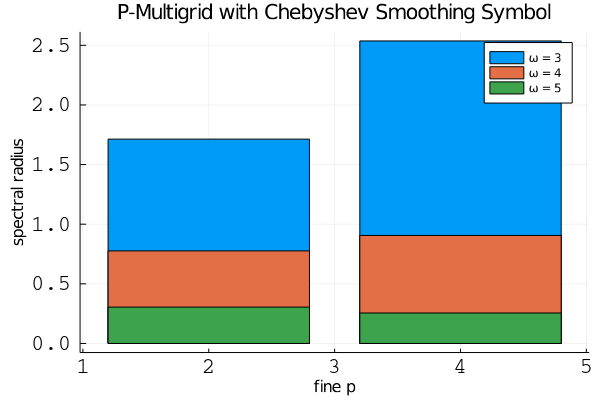

## <center>Development Roadmap</center>

<center>
<a href="https://www.github.com/jeremylt">github.com/jeremylt</a>
<br>
<a href="https://www.github.com/jeremylt/LFAToolkit.jl">github.com/jeremylt/LFAToolkit.jl</a>
</center>

* v0.2.1 released with preconditioners in this talk

* BDDC in current development<sup>[4]</sup>

* Parameter optimization examples

* Improved interoperability with libCEED.jl

* Contributors and friendly users welcome

## <center>Questions?</center>

<center>
<a href="https://www.github.com/jeremylt">github.com/jeremylt</a>
<br>
<a href="https://www.github.com/jeremylt/LFAToolkit.jl">github.com/jeremylt/LFAToolkit.jl</a>
</center>

## <center>References</center>

[1] A. Abdelfattah, V. Barra, N. Beams, J. Brown, J.S. Camier, V. Dobrev, Y. Dudouit, L. Ghaffari, T. Kolev, D. Medina, T. Rathnayake, J. L. Thompson,  and S. Tomov, *libCEED User Manual*, Zenodo (2020), https://doi.org/10.5281/zenodo.4302737.

[2] A. Brandt, *Multi-level adaptive solutions to boundary-value problems*, Math. Comp., 31(138) (1977), pp. 33-390.

[3] J. Brown, *Efficient nonlinear solvers for nodal high-order finite elements in 3D*, Journal of Scientific Computing, 45 (2010), pp. 48-63.

[4] J. Brown, Y. He, S. MacLachlan, *Local Fourier Analysis of Balancing Domain Decomposition by Constraints Algorithms*, SIAM Journal on Scientific Computing, 41 (2019), pp. S346-S369.

[5] M. Gutknecht and S. Röllin,  *The Chebyshev iteration revisited*, Parallel Computing, 28 (2002), pp. 263-283.

## <center>Backup</center>

## <center>Agressive Coarsening</center>
### <center>1D Scalar Diffusion - coarsen by half</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
numberpairs = 4
numbersmoothers = 3
maxeigenvalues = zeros(numberpairs, numbersmoothers)

for (finep, coarsep) in [(3, 2), (5, 3), (7, 4), (9, 5)]
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 100
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute effect of smoother
for w in 3:5
# -- 1D --
if dimension == 1
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[coarsep-1, w-2] = max(maxeigenvalues[coarsep-1, w-2], eigenvalues...)
        end
    end
# -- 2D --
elseif dimension == 2
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[coarsep-1, w-2] = max(maxeigenvalues[coarsep-1, w-2], eigenvalues...)
        end
    end
end
end
end

# plot
xrange = [2, 4, 6, 8]
bar(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 1],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 3",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 2],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 4",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 3],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 5",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)

## <center>Agressive Coarsening</center>
### <center>2D Scalar Diffusion - coarsen by half</center>

In [ ]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
numberpairs = 4
numbersmoothers = 3
maxeigenvalues = zeros(numberpairs, numbersmoothers)

for (finep, coarsep) in [(3, 2), (5, 3), (7, 4), (9, 5)]
numbercomponents = 1
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 100
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute effect of smoother
for w in 3:5
# -- 1D --
if dimension == 1
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[coarsep-1, w-2] = max(maxeigenvalues[coarsep-1, w-2], eigenvalues...)
        end
    end
# -- 2D --
elseif dimension == 2
    # setup
    ω = [w]
    v = [1, 1]

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[coarsep-1, w-2] = max(maxeigenvalues[coarsep-1, w-2], eigenvalues...)
        end
    end
end
end
end

# plot
xrange = [2, 4, 6, 8]
bar(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 1],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 3",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 2],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 4",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)
bar!(
    xrange,
    xlabel="fine p",
    xtickfont=font(12, "Courier"),
    maxeigenvalues[:, 3],
    ytickfont=font(12, "Courier"),
    ylabel="spectral radius",
    label="ω = 5",
    title="P-Multigrid with Chebyshev Smoothing Symbol"
)